In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    import mplleaflet
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [2]:

#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%

In [3]:
%%time
m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


CPU times: user 1min 4s, sys: 322 ms, total: 1min 5s
Wall time: 1min 5s


In [4]:
start_nm_yr = 1979
start_nm_mo = 10
start_nm_str = 'Oct 1979'
end_nm_yr = 2011
end_nm_mo = 9
end_nm_str = 'Sep 2011'
Lt_nm = ( (end_nm_yr + end_nm_mo/12)  - (start_nm_yr + start_nm_mo/12) )     *365
start_nm_datetime='{}/1/{}'.format(start_nm_mo,start_nm_yr)



# start_m_yr = 1979
# start_m_mo = 10
# start_m_str = 'Oct 1979'
# end_m_yr = 2011
# end_m_mo = 9
# end_m_str = 'Sep 2011'
# Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
# start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)


# start_m_yr = 1980
# start_m_mo = 3
# start_m_str = 'Mar 1980'


start_m_yr = 1990
start_m_mo = 3
start_m_str = 'Mar 1990'

end_m_yr = 2030
end_m_mo = 10
end_m_str = 'Sep 2030'
Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)






In [5]:
#Name model
modelname = 'SV'
model_ws = workdir.joinpath("SV")
#Name model
sw_exe = config.swexe #set the exe path for seawat

#Model discretization
Lz = 150.

nrow,ncol,nlay,nper = m_nm.nrow_ncol_nlay_nper

# rows = np.arange(100,102)
# rows = np.arange(100,102)
# rows = np.arange(m_nm.nrow-102,   m_nm.nrow-100) #NM super reduced

# rows = np.arange(nrow)
rows = np.arange(m_nm.nrow-159,   m_nm.nrow-132) #SV
# rows = np.arange(m_nm.nrow-114,   m_nm.nrow-74) #NM
# rows = np.arange(m_nm.nrow-114,   m_nm.nrow-95) #NM reduced, tsw included in domain

cols = np.arange(ncol)
nrow =len(rows) 
ncol = len(cols)
nlay=20


henry_top = 2
ocean_elev = 0
delv_first = 4
botm_first = henry_top-delv_first


delv = (Lz-delv_first) / (nlay-1)
delr = m_nm.dis.delr.array[0]
delc = m_nm.dis.delc.array[0]

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]


topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
henry_top = topo_grid[(slice(rows[0],rows[-1]+1),slice(cols[0],cols[-1]+1))]


# beachslope = .05
# ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
# ocean_col = [np.floor(ncol/2).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

# inland_elev = beachslope*ocean_col[0]*delr
# offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
# nyrs= 2
# Lt = 365*nyrs #Length of time in days

perlen = list(np.repeat(365/2,int(Lt_m/(365/2))))
nper = len(perlen)
nstp = np.ones_like(perlen,dtype=np.int)

# nstp = m_nm.dis.nstp.array
# perlen = m_nm.dis.perlen.array
# nper = m_nm.nper





steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.1
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt_m,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
# SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,
                               start_datetime=start_m_datetime)

xll=595855
yll = 4059438
rotation=-13.5
# p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

m.DIS.lenuni = 2
m.DIS.itmuni=4
m.DIS.rotation=-13.5
# m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m.DIS.proj4_str = p.srs
xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]


m.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)


np.save(model_ws.joinpath('rows.npy'),rows)
np.save(model_ws.joinpath('starttime.npy'),start_m_yr + start_m_mo/12)

Model setup: 
nlay: 20
nrow: 27
ncol: 345
Total cells: 186300
Total time: 14812.916666666639 days
nper: 81

SV.nam
adding Package:  DIS
xll:597733.4764816075; yll:4067262.41765696; rotation:-13.5; proj4_str:+proj=utm +zone=10 +datum=NAD83 +units=m +no_defs; units:undefined; lenuni:0


In [6]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())

flopy.modflow.ModflowDis(m_empty, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,start_datetime=start_m_datetime)

m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')

In [7]:
%%time
gridgen_ws = model_ws.joinpath('gridgen')
if not gridgen_ws.exists():
    gridgen_ws.mkdir()
g = Gridgen(m_empty.dis, model_ws=gridgen_ws.as_posix(),exe_name=config.gridgenexe,surface_interpolation='replicate')
g.build(verbose=False)

CPU times: user 9.03 s, sys: 544 ms, total: 9.57 s
Wall time: 35 s


In [8]:
f_swi_180 = GISdir.joinpath("chloride_contours",'SWI_180_lines_noz.shp').as_posix()
swi_180 = sf.Reader(f_swi_180)
yrs_180 = [ int(r[-1]) for r in swi_180.records()]


for yr in yrs_180:
    f_exp = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_180.fields[1:] # skip first deletion field
        for feature in swi_180.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)

f_swi_400 = GISdir.joinpath("chloride_contours",'SWI_400_lines_noz.shp').as_posix()
swi_400 = sf.Reader(f_swi_400)
yrs_400 = [ int(r[-1]) for r in swi_400.records()]


for yr in yrs_400:
    f_exp = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_400.fields[1:] # skip first deletion field
        for feature in swi_400.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)      
                

In [9]:
layer =3
yr = yrs_180[-1]
f_shp_180 = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
int_180 = g.intersect(f_shp_180,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_180.nodenumber] = 1
a180 = a.reshape((nlay,nrow,ncol),order='C')


yr = yrs_400[-1]
f_shp_400 = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
int_400 = g.intersect(f_shp_400,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_400.nodenumber] = 1
a400 = a.reshape((nlay,nrow,ncol),order='C')


In [10]:
def intersect_swi_contour(aquifer=180,yr_ind=None):
    if aquifer==180:
        yr = yrs_180[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    elif aquifer==400:
        yr = yrs_400[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    else:
        raise('enter either 180 or 400')
    int_obj = g.intersect(f,'polygon',layer=layer)
    a = np.zeros((g.nodes), dtype=np.int)
    a[int_obj.nodenumber] = 1
    return a.reshape((nlay,nrow,ncol),order='C')


from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata
def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)


In [11]:
botm_orig= m_nm.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros((nlay,nrow,ncol),dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
#         botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        botm_orig_lay = make_surf(botm_orig[-1],m_nm,m_empty)
        ind_inlay = m_empty.dis.botm.array<botm_orig_lay
    else:
        botm_orig_lay = make_surf(botm_orig[lay],m_nm,m_empty)
        top_orig_lay = make_surf(botm_orig[lay-1],m_nm,m_empty)
        ind_inlay =np.logical_and(m_empty.dis.botm.array>=botm_orig_lay,m_empty.dis.botm.array<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay
    
    
    
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


### Include holes in Aquitard

In [15]:
f_exp_thin = GISdir.joinpath("holes","holes_180400_thin").as_posix()
f_exp_well = GISdir.joinpath("holes","holes_180400_well").as_posix()


In [16]:
layer =3
g.nodes = g.get_nodes()

f_exp_thin = GISdir.joinpath("holes","holes_180400_thin").as_posix()
f_exp_well = GISdir.joinpath("holes","holes_180400_well").as_posix()

int_thin = g.intersect(f_exp_thin,'polygon',layer=layer)
int_well = g.intersect(f_exp_well,'polygon',layer=layer)

a = np.zeros((g.nodes), dtype=np.int)
a[int_thin.nodenumber] = 1
athin = a.reshape((nlay,nrow,ncol),order='C')

a = np.zeros((g.nodes), dtype=np.int)
a[int_well.nodenumber] = 1
awell = a.reshape((nlay,nrow,ncol),order='C')


/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy/utils/gridgen.py:1551: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  result = np.genfromtxt(fn, dtype=None, names=True, delimiter=',',


### Make well mask

In [18]:
# wellmsk = np.tile(awell[layer,:,:]==1,(m.nlay,1,1))
# wellmsk_in_aqt = np.logical_and(wellmsk,layer_mapping_ind==4)
# thinmsk = np.tile(athin[layer,:,:]==1,(m.nlay,1,1))
# thinmsk_in_aqt = np.logical_and(thinmsk,layer_mapping_ind==4)


model_ws_read = workdir.joinpath("SV")
if not model_ws_read.exists():
    model_ws_read.mkdir()


### Load well mask if already made

In [19]:
thinmsk_in_aqt = np.load(model_ws_read.joinpath('thinmsk_in_aqt.npy'))
wellmsk_in_aqt = np.load(model_ws_read.joinpath('wellmsk_in_aqt.npy'))
thinmsk_in_aqt = thinmsk_in_aqt[:,rows,:]
wellmsk_in_aqt = wellmsk_in_aqt[:,rows,:]


### Make thinning mask

In [20]:
hk_nm = m_nm.lpf.hk.array
x_nm = m_nm.modelgrid.xcellcenters
y_nm = m_nm.modelgrid.ycellcenters
z_nm = m_nm.modelgrid.zcellcenters
x_m = m_empty.modelgrid.xcellcenters
y_m = m_empty.modelgrid.ycellcenters
z_m = m_empty.modelgrid.zcellcenters
hkSand = 1e2 #horizontal hydraulic conductivity m/day
hkClay = hkSand*.001

#Set Hydraulic properties
sy = 0.15
ss = 1e-5
por = 0.3
vka = .5 # = vk/hk
al = 20 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

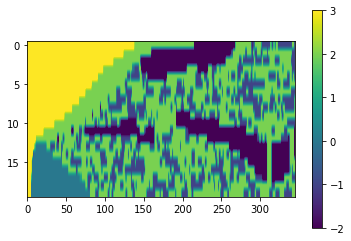

In [21]:
hk = np.ones((nlay,nrow,ncol),dtype=np.float64)
ibound = np.ones((nlay,nrow,ncol),dtype=np.int)

mps180 = np.load(MPSdir.joinpath('reals','mps180_16node.npy')).astype(np.float)
mps180[mps180==1]=hkSand
mps180[mps180==0]=hkClay
hk[np.where(layer_mapping_ind==0)] = 10000
hk[np.where(layer_mapping_ind==1)] = 100
hk[np.where(layer_mapping_ind==2)] = hkClay*.01
hk[np.where(layer_mapping_ind==3)] = mps180[np.where(layer_mapping_ind==3)]
hk[np.where(layer_mapping_ind==4)] = hkClay*.01
hk[np.where(layer_mapping_ind==5)] = mps180[np.where(layer_mapping_ind==5)]



hk[np.where(wellmsk_in_aqt)]=hkSand
hk[np.where(thinmsk_in_aqt)]=hkSand





plt.figure()
plt.imshow(np.log10(hk)[:,0,:],vmin=-2,vmax=3)
plt.gca().set_aspect(10)
plt.colorbar()

### BCs

In [22]:
def find_ocean(m,layer_mapping_ind):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((nlay,nrow,ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m,layer_mapping_ind)

In [23]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
cond = 1000.

ghb_data_ocean = {}
ssm_data_ocean = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = []
    ssm_per = []
    #Ocean boundary
    for v in np.argwhere(ocean_grid):
        ghb_per.append([v[0],
                       v[1],
                       v[2],
                       #ocean_hf[3][j],
                        ocean_elev,
                       cond])
        #SSM: {stress_period: [lay,row,col,concentration,itype]}
        ssm_per.append([v[0],
                       v[1],
                       v[2],
                       Csalt,
                       itype['GHB']])
    ghb_data_ocean[kper]=ghb_per
    ssm_data_ocean[kper]=ssm_per

    
    
# print(np.where(ibound[tuple(np.array(ghb_data_ocean[0])[:,:3].astype(int).T)]==0))

inds = []
nix_ghb = []
for v in ocean_line.T:
# v = ocean_line.T[-1]
    if 6 in layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]:
        inds.append((v[0],v[1],int(np.argwhere(layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]==6)[0]) + v[2]))
        nix_ghb.append(v)

        
for kper in range(nper):
    for v in nix_ghb:
        try:
            ghb_data_ocean[kper].remove([v[0],v[1],v[2],0,cond])
            ssm_data_ocean[kper].remove([v[0],v[1],v[2],Csalt,itype['GHB']])
        except:
            continue


kper 0
kper 50


### Extend inland ghb time

In [24]:
bhead_mean_180=  []
bhead_mean_400 = []
bhead_180400 = []

for per in range(m_nm.nper):
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==3)
    bhead_mean_180.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==5)
    bhead_mean_400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==4)
    bhead_180400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    
    
    
yr = np.arange(2012,2019)
dlvl_180 = np.array([-2,-1,-8,-7,0,11,.5,2])*.3048
dlvl_400 = np.array([-1,-1,-7,-4,1,8,-.5,2])*.3048

bhead_future_180 = [np.array(bhead_mean_180)[-12:]+dlvl for dlvl in dlvl_180]
bhead_future_180 = np.array(bhead_future_180).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]
bhead_future_180 = bhead_future_180[5::6]

bhead_future_400 = [np.array(bhead_mean_400)[-12:]+dlvl for dlvl in dlvl_400]
bhead_future_400 = np.array(bhead_future_400).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]
bhead_future_400 = bhead_future_400[5::6]


inland_inds_180 = np.argwhere(layer_mapping_ind==3)
inland_inds_180 = inland_inds_180[inland_inds_180[:,2]==344,:]

inland_inds_180400 = np.argwhere(layer_mapping_ind==4)
inland_inds_180400 = inland_inds_180400[inland_inds_180400[:,2]==344,:]

inland_inds_400 = np.argwhere(layer_mapping_ind==5)
inland_inds_400 = inland_inds_400[inland_inds_400[:,2]==344,:]



In [27]:
z_m_vert = m_empty.modelgrid.zvertices
ghb_data_nm = m_nm.ghb.stress_period_data.data
def date_from_per(kper_m):
    return  (start_m_yr + start_m_mo/12) + np.sum(perlen[:kper_m])/365


bheads180 = []
bheads400 = []
dates = []
for kper_nm in range(m_nm.nper):
    ghb_per=[]
    ssm_per = []


    lay=3
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads180.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())

    lay=5
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads400.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())
    dates.append((start_nm_yr + start_nm_mo/12) + kper_nm/12)
    
    
bhead_future_180 = np.array([np.array(bheads180)[-12:]+dlvl for dlvl in dlvl_180]).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]

bhead_future_400 = np.array([np.array(bheads400)[-12:]+dlvl for dlvl in dlvl_400]).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]

dates_future = dates[-1] + np.linspace(1/12,1/12*len(bhead_future_180),len(bhead_future_180))


bheads180 = np.r_[bheads180,bhead_future_180]
bheads400 = np.r_[bheads400,bhead_future_400]
dates  = np.r_[dates,dates_future]


    
    
###Smooth and sample
    
from scipy.interpolate import interp1d

def conv_signal(x,N=2):
    bheads_conv = np.convolve(x, np.ones((N,))/N, mode='valid')
    if N%2==0:
        return np.r_[np.ones(int(np.floor((N-1)/2)))*bheads_conv[0],
                            bheads_conv,
                            np.ones(int(np.ceil((N-1)/2)))*bheads_conv[-1] ]
    else:
        return np.r_[np.ones(int((N-1)/2))*bheads_conv[0],
                     bheads_conv,
                     np.ones(int((N-1)/2))*bheads_conv[-1]]
    
    
dates_m = np.array([date_from_per(kper) for kper in range(m.nper)])
interpolator = interp1d(dates,conv_signal(bheads400,12),kind='cubic')

bheads180_interp = interp1d(dates,conv_signal(bheads180,12),kind='cubic')(dates_m)
bheads400_interp = interp1d(dates,conv_signal(bheads400,12),kind='cubic')(dates_m)


plt.plot(dates_m,bheads180_interp)
plt.plot(dates_m,bheads400_interp)
    
    
ghb_data_inland = {}
ssm_data_inland = {}
#Assign
for per in range(m.nper):
    ghb_per=[]
    ssm_per = []
    if per%10==0:
        print('kper_m {}, date {}'.format(per,dates_m[per]))
            
    for ind in inland_inds_180:
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_180400: #Same bhead as 180-FA
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_400:
        k,i,j = ind
        bhead =bheads400_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])
        
    ghb_data_inland[per]=ghb_per
    ssm_data_inland[per]=ssm_per  

kper_m 0, date 1990.25
0 0 344 -24.16293239593505
0 1 344 -24.16293239593505
0 2 344 -24.16293239593505
0 3 344 -24.16293239593505
0 4 344 -24.16293239593505
0 5 344 -24.16293239593505
0 6 344 -24.16293239593505
0 7 344 -24.16293239593505
0 8 344 -24.16293239593505
0 9 344 -24.16293239593505
0 10 344 -24.16293239593505
0 11 344 -24.16293239593505
0 12 344 -24.16293239593505
0 13 344 -24.16293239593505
0 14 344 -24.16293239593505
0 15 344 -24.16293239593505
0 16 344 -24.16293239593505
0 17 344 -24.16293239593505
0 18 344 -24.16293239593505
0 19 344 -24.16293239593505
0 20 344 -24.16293239593505
0 21 344 -24.16293239593505
0 22 344 -24.16293239593505
0 23 344 -24.16293239593505
0 24 344 -24.16293239593505
0 25 344 -24.16293239593505
0 26 344 -24.16293239593505
1 0 344 -16.478721618652337
1 1 344 -16.478721618652337
1 2 344 -16.478721618652337
1 3 344 -16.478721618652337
1 4 344 -16.478721618652337
1 5 344 -16.478721618652337
1 6 344 -16.478721618652337
1 7 344 -16.478721618652337
1 8 344

0 16 344 -28.106976350148525
0 17 344 -28.106976350148525
0 18 344 -28.106976350148525
0 19 344 -28.106976350148525
0 20 344 -28.106976350148525
0 21 344 -28.106976350148525
0 22 344 -28.106976350148525
0 23 344 -28.106976350148525
0 24 344 -28.106976350148525
0 25 344 -28.106976350148525
0 26 344 -28.106976350148525
1 0 344 -20.42276557286581
1 1 344 -20.42276557286581
1 2 344 -20.42276557286581
1 3 344 -20.42276557286581
1 4 344 -20.42276557286581
1 5 344 -20.42276557286581
1 6 344 -20.42276557286581
1 7 344 -20.42276557286581
1 8 344 -20.42276557286581
1 9 344 -20.42276557286581
1 10 344 -20.42276557286581
1 11 344 -20.42276557286581
1 12 344 -20.42276557286581
1 13 344 -20.42276557286581
1 14 344 -20.42276557286581
1 15 344 -20.42276557286581
1 16 344 -20.42276557286581
1 17 344 -20.42276557286581
1 18 344 -20.42276557286581
1 19 344 -20.42276557286581
1 20 344 -20.42276557286581
1 21 344 -20.42276557286581
1 22 344 -20.42276557286581
1 23 344 -20.42276557286581
1 24 344 -20.422765

0 0 344 -19.936543385187786
0 1 344 -19.936543385187786
0 2 344 -19.936543385187786
0 3 344 -19.936543385187786
0 4 344 -19.936543385187786
0 5 344 -19.936543385187786
0 6 344 -19.936543385187786
0 7 344 -19.936543385187786
0 8 344 -19.936543385187786
0 9 344 -19.936543385187786
0 10 344 -19.936543385187786
0 11 344 -19.936543385187786
0 12 344 -19.936543385187786
0 13 344 -19.936543385187786
0 14 344 -19.936543385187786
0 15 344 -19.936543385187786
0 16 344 -19.936543385187786
0 17 344 -19.936543385187786
0 18 344 -19.936543385187786
0 19 344 -19.936543385187786
0 20 344 -19.936543385187786
0 21 344 -19.936543385187786
0 22 344 -19.936543385187786
0 23 344 -19.936543385187786
0 24 344 -19.936543385187786
0 25 344 -19.936543385187786
0 26 344 -19.936543385187786
1 0 344 -12.252332607905071
1 1 344 -12.252332607905071
1 2 344 -12.252332607905071
1 3 344 -12.252332607905071
1 4 344 -12.252332607905071
1 5 344 -12.252332607905071
1 6 344 -12.252332607905071
1 7 344 -12.252332607905071
1 8

0 13 344 -6.398672938346865
0 14 344 -6.398672938346865
0 15 344 -6.398672938346865
0 16 344 -6.398672938346865
0 17 344 -6.398672938346865
0 18 344 -6.398672938346865
0 19 344 -6.398672938346865
0 20 344 -6.398672938346865
0 21 344 -6.398672938346865
0 22 344 -6.398672938346865
0 23 344 -6.398672938346865
0 24 344 -6.398672938346865
0 25 344 -6.398672938346865
0 26 344 -6.398672938346865
0 0 344 -7.549568116664888
0 1 344 -7.549568116664888
0 2 344 -7.549568116664888
0 3 344 -7.549568116664888
0 4 344 -7.549568116664888
0 5 344 -7.549568116664888
0 6 344 -7.549568116664888
0 7 344 -7.549568116664888
0 8 344 -7.549568116664888
0 9 344 -7.549568116664888
0 10 344 -7.549568116664888
0 11 344 -7.549568116664888
0 12 344 -7.549568116664888
0 13 344 -7.549568116664888
0 14 344 -7.549568116664888
0 15 344 -7.549568116664888
0 16 344 -7.549568116664888
0 17 344 -7.549568116664888
0 18 344 -7.549568116664888
0 19 344 -7.549568116664888
0 20 344 -7.549568116664888
0 21 344 -7.549568116664888
0 

2 0 344 -1.7475971380869524
2 1 344 -1.7475971380869524
2 2 344 -1.7475971380869524
2 3 344 -1.7475971380869524
2 4 344 -1.7475971380869524
2 5 344 -1.7475971380869524
2 6 344 -1.7475971380869524
2 7 344 -1.7475971380869524
2 8 344 -1.7475971380869524
2 9 344 -1.7475971380869524
2 10 344 -1.7475971380869524
2 11 344 -1.7475971380869524
2 12 344 -1.7475971380869524
2 13 344 -1.7475971380869524
2 14 344 -1.7475971380869524
2 15 344 -1.7475971380869524
2 16 344 -1.7475971380869524
2 17 344 -1.7475971380869524
2 18 344 -1.7475971380869524
2 19 344 -1.7475971380869524
2 20 344 -1.7475971380869524
2 21 344 -1.7475971380869524
2 22 344 -1.7475971380869524
2 23 344 -1.7475971380869524
2 24 344 -1.7475971380869524
2 25 344 -1.7475971380869524
2 26 344 -1.7475971380869524
0 0 344 -15.07358066240947
0 1 344 -15.07358066240947
0 2 344 -15.07358066240947
0 3 344 -15.07358066240947
0 4 344 -15.07358066240947
0 5 344 -15.07358066240947
0 6 344 -15.07358066240947
0 7 344 -15.07358066240947
0 8 344 -15

0 4 344 -20.47049363454183
0 5 344 -20.47049363454183
0 6 344 -20.47049363454183
0 7 344 -20.47049363454183
0 8 344 -20.47049363454183
0 9 344 -20.47049363454183
0 10 344 -20.47049363454183
0 11 344 -20.47049363454183
0 12 344 -20.47049363454183
0 13 344 -20.47049363454183
0 14 344 -20.47049363454183
0 15 344 -20.47049363454183
0 16 344 -20.47049363454183
0 17 344 -20.47049363454183
0 18 344 -20.47049363454183
0 19 344 -20.47049363454183
0 20 344 -20.47049363454183
0 21 344 -20.47049363454183
0 22 344 -20.47049363454183
0 23 344 -20.47049363454183
0 24 344 -20.47049363454183
0 25 344 -20.47049363454183
0 26 344 -20.47049363454183
1 0 344 -12.786282857259113
1 1 344 -12.786282857259113
1 2 344 -12.786282857259113
1 3 344 -12.786282857259113
1 4 344 -12.786282857259113
1 5 344 -12.786282857259113
1 6 344 -12.786282857259113
1 7 344 -12.786282857259113
1 8 344 -12.786282857259113
1 9 344 -12.786282857259113
1 10 344 -12.786282857259113
1 11 344 -12.786282857259113
1 12 344 -12.78628285725

0 22 344 -12.646003643671675
0 23 344 -12.646003643671675
0 24 344 -12.646003643671675
0 25 344 -12.646003643671675
0 26 344 -12.646003643671675
1 0 344 -4.96179286638896
1 1 344 -4.96179286638896
1 2 344 -4.96179286638896
1 3 344 -4.96179286638896
1 4 344 -4.96179286638896
1 5 344 -4.96179286638896
1 6 344 -4.96179286638896
1 7 344 -4.96179286638896
1 8 344 -4.96179286638896
1 9 344 -4.96179286638896
1 10 344 -4.96179286638896
1 11 344 -4.96179286638896
1 12 344 -4.96179286638896
1 13 344 -4.96179286638896
1 14 344 -4.96179286638896
1 15 344 -4.96179286638896
1 16 344 -4.96179286638896
1 17 344 -4.96179286638896
1 18 344 -4.96179286638896
1 19 344 -4.96179286638896
1 20 344 -4.96179286638896
1 21 344 -4.96179286638896
1 22 344 -4.96179286638896
1 23 344 -4.96179286638896
1 24 344 -4.96179286638896
1 25 344 -4.96179286638896
1 26 344 -4.96179286638896
0 0 344 -13.712803681691486
0 1 344 -13.712803681691486
0 2 344 -13.712803681691486
0 3 344 -13.712803681691486
0 4 344 -13.712803681691

0 0 344 -12.188803990681963
0 1 344 -12.188803990681963
0 2 344 -12.188803990681963
0 3 344 -12.188803990681963
0 4 344 -12.188803990681963
0 5 344 -12.188803990681963
0 6 344 -12.188803990681963
0 7 344 -12.188803990681963
0 8 344 -12.188803990681963
0 9 344 -12.188803990681963
0 10 344 -12.188803990681963
0 11 344 -12.188803990681963
0 12 344 -12.188803990681963
0 13 344 -12.188803990681963
0 14 344 -12.188803990681963
0 15 344 -12.188803990681963
0 16 344 -12.188803990681963
0 17 344 -12.188803990681963
0 18 344 -12.188803990681963
0 19 344 -12.188803990681963
0 20 344 -12.188803990681963
0 21 344 -12.188803990681963
0 22 344 -12.188803990681963
0 23 344 -12.188803990681963
0 24 344 -12.188803990681963
0 25 344 -12.188803990681963
0 26 344 -12.188803990681963
1 0 344 -4.504593213399248
1 1 344 -4.504593213399248
1 2 344 -4.504593213399248
1 3 344 -4.504593213399248
1 4 344 -4.504593213399248
1 5 344 -4.504593213399248
1 6 344 -4.504593213399248
1 7 344 -4.504593213399248
1 8 344 -4.

1 5 344 -4.047392765680952
1 6 344 -4.047392765680952
1 7 344 -4.047392765680952
1 8 344 -4.047392765680952
1 9 344 -4.047392765680952
1 10 344 -4.047392765680952
1 11 344 -4.047392765680952
1 12 344 -4.047392765680952
1 13 344 -4.047392765680952
1 14 344 -4.047392765680952
1 15 344 -4.047392765680952
1 16 344 -4.047392765680952
1 17 344 -4.047392765680952
1 18 344 -4.047392765680952
1 19 344 -4.047392765680952
1 20 344 -4.047392765680952
1 21 344 -4.047392765680952
1 22 344 -4.047392765680952
1 23 344 -4.047392765680952
1 24 344 -4.047392765680952
1 25 344 -4.047392765680952
1 26 344 -4.047392765680952
0 0 344 -11.731603542963665
0 1 344 -11.731603542963665
0 2 344 -11.731603542963665
0 3 344 -11.731603542963665
0 4 344 -11.731603542963665
0 5 344 -11.731603542963665
0 6 344 -11.731603542963665
0 7 344 -11.731603542963665
0 8 344 -11.731603542963665
0 9 344 -11.731603542963665
0 10 344 -11.731603542963665
0 11 344 -11.731603542963665
0 12 344 -11.731603542963665
0 13 344 -11.731603542

0 0 344 -11.731603542963667
0 1 344 -11.731603542963667
0 2 344 -11.731603542963667
0 3 344 -11.731603542963667
0 4 344 -11.731603542963667
0 5 344 -11.731603542963667
0 6 344 -11.731603542963667
0 7 344 -11.731603542963667
0 8 344 -11.731603542963667
0 9 344 -11.731603542963667
0 10 344 -11.731603542963667
0 11 344 -11.731603542963667
0 12 344 -11.731603542963667
0 13 344 -11.731603542963667
0 14 344 -11.731603542963667
0 15 344 -11.731603542963667
0 16 344 -11.731603542963667
0 17 344 -11.731603542963667
0 18 344 -11.731603542963667
0 19 344 -11.731603542963667
0 20 344 -11.731603542963667
0 21 344 -11.731603542963667
0 22 344 -11.731603542963667
0 23 344 -11.731603542963667
0 24 344 -11.731603542963667
0 25 344 -11.731603542963667
0 26 344 -11.731603542963667
1 0 344 -4.047392765680952
1 1 344 -4.047392765680952
1 2 344 -4.047392765680952
1 3 344 -4.047392765680952
1 4 344 -4.047392765680952
1 5 344 -4.047392765680952
1 6 344 -4.047392765680952
1 7 344 -4.047392765680952
1 8 344 -4.

### Merge GHB data, SSM data

In [30]:
ghb_data = {}
ssm_data = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = ghb_data_ocean[kper]
    ssm_per = ssm_data_ocean[kper]
    for vg,vs in zip(ghb_data_inland[kper],ssm_data_inland[kper]):
        ghb_per.append(vg)
        ssm_per.append(vs)
        
    ghb_data[kper] = ghb_per
    ssm_data[kper] = ssm_per

kper 0
kper 50


 ### STRT

In [31]:
yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_180]))
a_180 = intersect_swi_contour(aquifer=180,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_180]))
a_180 = np.tile(a_180[nonzerolay],(nlay,1,1))


yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_400]))
a_400 = intersect_swi_contour(aquifer=400,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_400]))
a_400 = np.tile(a_400[nonzerolay],(nlay,1,1))
salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)


salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_180[lay,row,:])
        if len(inds_nonzero)>0:
            salt_180[lay,row,:int(inds_nonzero[0])]=True
            
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_400[lay,row,:])
        if len(inds_nonzero)>0:
            salt_400[lay,row,:int(inds_nonzero[0])]=True


In [32]:
ind_ocean = np.where(ocean_grid[0,0,:])[0].max()
# ocean_lay = np.where((layer_mapping_ind[:,row,:]==3).any(axis=1))[0].min() # highest layer within the 180-FA containing the ocean
# ind_ocean = np.where(ocean_grid[ocean_lay,0,:])[0].max() #farthest inland point for the given row corresponding to the ocean



saltgrad_180 = np.zeros_like(a_180)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_180[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_180[lay,row,:ind_ocean]=Csalt
            saltgrad_180[lay,row,ind_ocean:ind_max.max()]=tds_vec
saltgrad_400 = np.zeros_like(a_400)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_400[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_400[lay,row,:ind_ocean]=Csalt
            saltgrad_400[lay,row,ind_ocean:ind_max.max()]=tds_vec
 
            
            

In [33]:
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
# for v in np.argwhere(ocean_grid):
#     ibound[v[0],v[1],:v[2]]=0
# head_inland =-10.
head_inland = min([np.min(np.array(v)[:,3]) for k,v in ghb_data_inland.items()])
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
for lay in range(nlay):
    for row in range(nrow):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        ibound[lay,row,:col]=0
for v in inds:
    ibound[v[0],v[1],:v[2]]=0
# ibound[z_m_vert[1:,:,:]>0]=0
ibound[m_empty.modelgrid.zcellcenters > -1] = 0 
ibound[layer_mapping_ind==6]=0


strt = np.ones_like(ibound)*head_inland

# sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
# sconc[ocean_grid] = Csalt
# # interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
# for v in ocean_line.T:
#     sconc[v[0],v[1],:v[2]]=Csalt
# sconc[np.logical_or(salt_180,salt_400)] = Csalt
    
sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
sconc[np.isin(layer_mapping_ind,(3,1))] = saltgrad_180[np.isin(layer_mapping_ind,(3,1))]
sconc[np.isin(layer_mapping_ind,(5,1))] = saltgrad_400[np.isin(layer_mapping_ind,(5,1))]
# sconc[layer_mapping_ind==1] =Csalt
sconc[ocean_grid] = Csalt
# interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
for v in ocean_line.T:
    sconc[v[0],v[1],:v[2]]=Csalt
    
    
    

icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[np.where(ibound==-1)] = -1

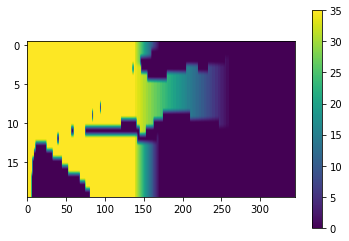

In [34]:
plt.imshow(sconc[:,0,:])
plt.gca().set_aspect(10)
plt.colorbar()

In [35]:
# In[9]:

#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']


# In[10]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

# if rch_how is 'CHD':
#     chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
# elif rch_how is 'RCH':
#     rch = flopy.modflow.ModflowRch(m,rech=rech_data)

# rch = flopy.modflow.ModflowRch(m, rech=rech_data)
# wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
# riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)
# Add LPF package to the MODFLOW model
ipakcb = 53
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=0,laywet=0,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
timprs = np.cumsum(m.DIS.perlen.array)
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=lpf.laytyp, htop=henry_top,
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
# adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1 )
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0,nadvfd=0 )

dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=3, cclose=1e-4)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data,mxss=len(ssm_data[0])*nper)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


# for pak in ['RCH','CHD',]:
#     if pak is not rch_how:
#         try:
#             m.remove_package(pak)
#         except:
#             pass

adding Package:  BAS6
adding Package:  GHB
Adding SV.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding SV.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
   explicit cevt in file
adding Package:  SSM
adding Package:  VDF


In [47]:
import set_rc
set_rc.set_rc()

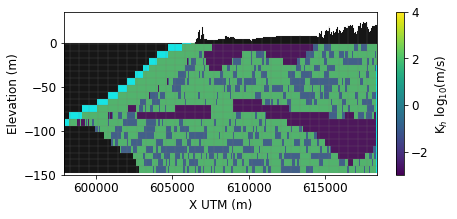

In [49]:
from matplotlib import cm

slicetype='Row'
slicenum= int(len(rows)/2)

# First step is to set up the plot
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(1,1,1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(np.log10(hk),cmap='viridis')
# csa = xsect.contour_array(sconc,levels=np.array((.05,.5,.95))*Csalt,cmap='jet')
c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")

# wel = xsect.plot_bc("RCH")

# wel = xsect.plot_bc("CHD")

# csa = xsect.plot_array(m.bas6.ibound,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
# ax.set_title('Salinas Valley Cros')
plt.ylabel('Elevation (m)')
plt.ylim((-150,35))
plt.xlabel('X UTM (m)')
c.set_label('K$_{h}$ log$_{10}$(m/s) ')
plt.savefig(figdir.joinpath('seawat_SV_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

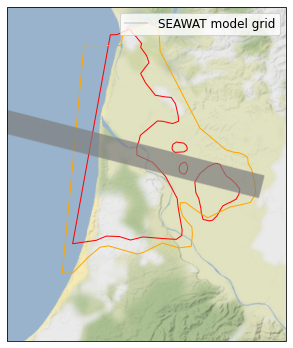

In [50]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid',alpha=.3)




ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)



# plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='k',s=.5,transform=transform,label='AEM data ')


shp180 =  flopy.plot.plot_shapefile(f_shp_400,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='r',label='Cl. contour 180-FA')
shp400 =flopy.plot.plot_shapefile(f_shp_180,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='orange',label='Cl. contour 400-FA')
plt.legend()

In [ ]:
%%time
writeyn= True
runyn = True
#Write input
if writeyn:
    print('Writing to {}'.format(m.model_ws))
    m.write_input()

# Try to delete the output files, to prevent accidental use of older files

f_delete = [os.path.join(model_ws,'MT3D.CNF'),
            os.path.join(model_ws,'MT3D001.MAS'),
            os.path.join(model_ws, 'MT3D001.UCN'),
            os.path.join(model_ws, modelname + '.hds'),
            os.path.join(model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%
import datetime

if runyn:
    #Run model
    ts = make_timestamp()
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')
# In[14]:

Writing to /scratch/users/ianpg/SWIlarge/work/SV

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 
FloPy is using the following  executable to run the model: /home/groups/rknight/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: SV.nam                                 

### Post processing

In [996]:
fname = model_ws.joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
for kstpkper in kstpkpers:
    conc = ucnobj.get_data(kstpkper=kstpkper)
    anyvals.append(np.logical_and(conc < 100., conc>0.).any())
print(anyvals)


conc = ucnobj.get_data(kstpkper=kstpkpers[-1])
conc[conc > 100]=np.nan


fname = model_ws.joinpath(m.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)
kstpkpers = hdobj.get_kstpkper()
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd[hd<-100]=np.nan

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


Text(0.5, 0, 'X UTM (m)')

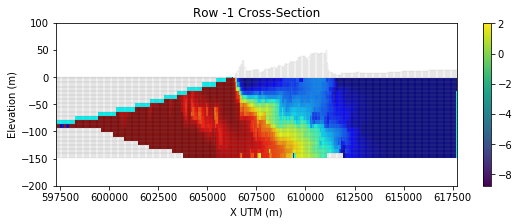

In [998]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# xsect.contour_array(conc,cmap='jet',levels=np.array([.05,.5,.95])*Csalt)
xsect.plot_array(conc,cmap='jet',vmin=Cfresh,vmax=Csalt)
# csa = xsect.plot_array(hd)

c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_bc("GHB")



t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('X UTM (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')